In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
image_dir = '/content/drive/My Drive/cavallo'

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (120, 120))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


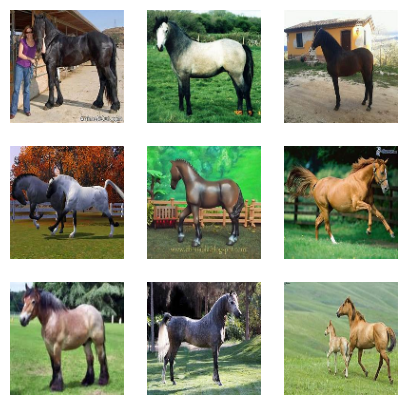

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [5]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3

    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)

    return parts

In [6]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))

    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())

    return combinations, original_positions

In [7]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square

    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)

    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]

    return stitched_image

In [8]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)

    for idx, combination in enumerate(combinations):
        shuffled_image = stitch_shuffled_image(combination)
        input_data.append(shuffled_image)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [9]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 120, 120, 3)
Target data shape: (26230, 81)


target
[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0]]
non_converted_target [3, 6, 2, 8, 4, 5, 1, 7, 0]


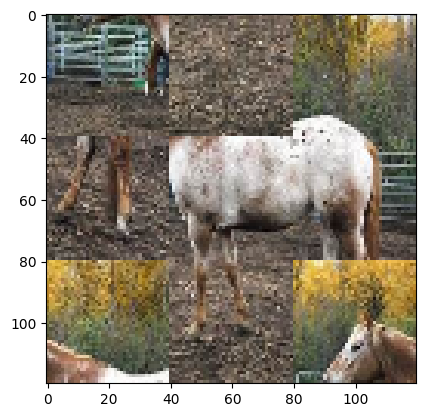

In [10]:
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(input_data[idx], cv2.COLOR_BGR2RGB))

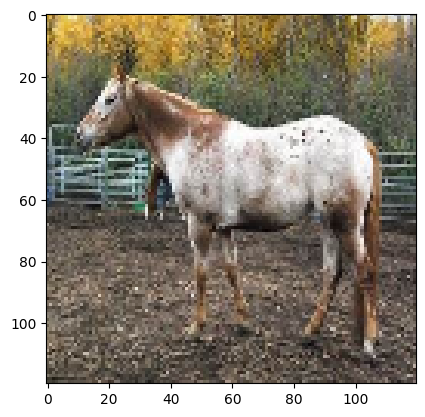

In [11]:
def reconstructed_image(img, non_converted_target_data):

    parts = divide_image(img)
    sequenced = [0] * 9
    for i, part in enumerate(parts):
        sequenced[non_converted_target_data[i]] = part

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img

reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [12]:
import torch.optim as optim


num_epochs = 10
batch_size = 64

In [13]:
# class JigsawDataset(Dataset):
#     def __init__(self, input_data, target_data, transform=None):
#         self.input_data = input_data
#         self.target_data = target_data
#         self.transform = transform

#     def __len__(self):
#         return len(self.input_data)

#     def __getitem__(self, idx):
#         image = self.input_data[idx]
#         target = self.target_data[idx]

#         if self.transform:
#             image = self.transform(image)

#         return image, target

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

# train_dataset = JigsawDataset(X_train, y_train)
# test_dataset = JigsawDataset(X_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [15]:
class PieceDataset(Dataset):
    def __init__(self, pieces, transform=None):
        self.pieces = pieces
        self.transform = transform

    def __len__(self):
        return len(self.pieces)

    def __getitem__(self, idx):
        piece = self.pieces[idx]
        if self.transform:
            piece = self.transform(piece)
        return piece


In [16]:
pieces_data = []

for image in images:
    parts = divide_image(image)
    pieces_data.extend(parts)

pieces_data = np.array(pieces_data)


In [17]:
X_train, X_test = train_test_split(pieces_data, test_size=0.2, random_state=42)

train_dataset = PieceDataset(X_train)
test_dataset = PieceDataset(X_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)


In [18]:
from google.colab import files
src = list(files.upload().values())[0]
open('clip_model.py','wb').write(src)
import clip_model

Saving clip_model.py to clip_model.py


In [19]:
from clip_model import ModifiedResNet
model = ModifiedResNet(layers=[3, 4, 6, 3], output_dim=1000, heads=8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
model.train()  # Set the model to training mode

#feature_list = []
features_list = []

for epoch in range(num_epochs):
    running_loss = 0.0

#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data

#         inputs = inputs.permute(0, 3, 1, 2).float()


    for data in train_loader:
        inputs = data.float()
        inputs = inputs.permute(0, 3, 1, 2)  # Adjust depending on your model's expected input format

        # Assuming model has a method to return features
        #features = model.extract_features(inputs)

        features_list.append(inputs)


        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs,features = model(inputs,features_list)  # Adjust this if your model returns more than one output



        break
        # Compute the loss
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
    break
print('Finished Training')

2048 tensor([[[[0.0000]],

         [[0.8770]],

         [[3.1621]],

         ...,

         [[1.0129]],

         [[0.8359]],

         [[1.0314]]],


        [[[1.7475]],

         [[0.0000]],

         [[0.2131]],

         ...,

         [[1.0329]],

         [[0.4175]],

         [[0.0913]]],


        [[[1.9497]],

         [[0.7026]],

         [[2.6118]],

         ...,

         [[0.0000]],

         [[0.0000]],

         [[0.0000]]],


        ...,


        [[[0.0000]],

         [[1.0750]],

         [[0.0000]],

         ...,

         [[1.2628]],

         [[1.3452]],

         [[1.5049]]],


        [[[0.0000]],

         [[0.4996]],

         [[0.0784]],

         ...,

         [[0.0000]],

         [[0.7534]],

         [[0.8185]]],


        [[[0.6690]],

         [[0.0000]],

         [[0.0000]],

         ...,

         [[0.9263]],

         [[0.1043]],

         [[2.8429]]]], grad_fn=<ReluBackward0>)
torch.Size([2, 64, 2048])
torch.Size([17, 1, 2048])


RuntimeError: The size of tensor a (2) must match the size of tensor b (17) at non-singleton dimension 0

In [21]:
features_list[0][0].shape


torch.Size([3, 40, 40])

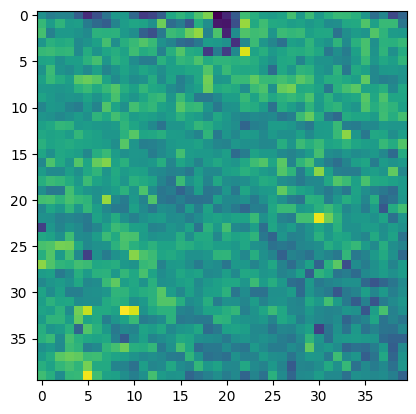

In [22]:
plt.imshow(features_list[0][0][0].detach().numpy())


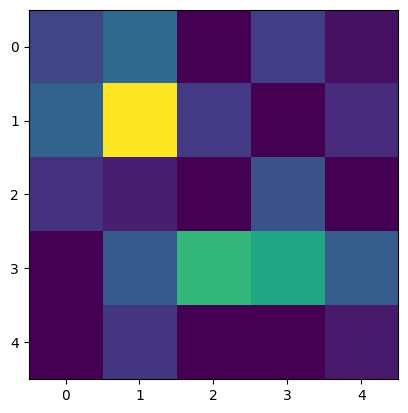

In [23]:
plt.imshow(features_list[1][0][0].detach().numpy())
